# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

import optimization
import plotting

import warnings

warnings.filterwarnings("ignore")

# Data & Constants

In [2]:
np.random.seed(101)
T = 60  # length of each timeseries
N = 49  # nb of assets
risk_free = 0.4  # taken from latest observation of risk-free rate in Kenneth French Library
start_date = "2019-12-01"
nb_bootstraps = 10000

In [3]:
data_path = str(Path().absolute()) + "/data_will/48_industry_Portfolios.CSV"
df_global = pd.read_csv(data_path, index_col=0)
df_global.index = pd.to_datetime(df_global.index, format="%Y%m")  # clean the index to be datetime
df_global.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1926-07-01,2.37,0.12,-99.99,-5.19,1.29,8.65,2.50,50.21,-0.48,8.08,...,7.70,1.92,-23.79,0.07,1.87,4.61,-0.54,2.89,-5.77,5.20
1926-08-01,2.23,2.68,-99.99,27.03,6.50,16.81,-0.76,42.98,-3.58,-2.51,...,-2.38,4.85,5.39,-0.75,-0.13,11.83,2.57,5.30,0.32,6.76
1926-09-01,-0.57,1.58,-99.99,4.02,1.26,8.33,6.42,-4.91,0.73,-0.51,...,-5.54,0.08,-7.87,0.25,-0.56,-1.75,0.72,-3.06,-4.81,-3.86
1926-10-01,-0.46,-3.68,-99.99,-3.31,1.06,-1.40,-5.09,5.37,-4.68,0.12,...,-5.08,-2.62,-15.38,-2.20,-4.11,-11.82,-4.28,-5.74,-0.94,-8.49
1926-11-01,6.75,6.26,-99.99,7.29,4.55,0.00,1.82,-6.40,-0.54,1.87,...,3.84,1.61,4.67,6.52,4.33,-2.97,3.58,2.21,5.13,4.00


In [4]:
df_global = df_global.loc[df_global.index >= start_date, :]  # select last 5 years
df = df_global.loc[:, ["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "]]  # select 5 assets to work with
rf = pd.DataFrame(risk_free, index=df.index, columns=["risk-free"])
df_rf = pd.concat([rf, df], axis=1)

# Variables to Store Results

In [5]:
bootstraps = np.zeros(shape=[nb_bootstraps, T, N])  # bootstrapped samples

# list of target returns with and without short sales
target_returns = np.arange(-8, 8, 0.04)
nb_no_short_targets = 20  # nb of target returns to compute for each mean-variance locus (no short)
nb_targets = len(target_returns) # nb of target returns to compute for each mean-variance locus 
target_returns_no_short = np.linspace(-2, 4, nb_no_short_targets)
target_returns_no_short_rf = np.linspace(0.4, 4, nb_no_short_targets)


# no short sale constraint results
no_rf_mean_var_locus = np.zeros(shape=[nb_bootstraps, nb_targets, 2])  # no rf rate bootstrapped mean-var locus
rf_mean_var_locus = np.zeros(shape=[nb_bootstraps, nb_targets, 2])  # rf rate bootstrapped mean-var locus
tangency_portfolio = np.zeros(shape=[nb_bootstraps, 2])  # tangency portfolio bootstrapped mean-var
tangency_portfolio_weights = np.zeros(shape=[nb_bootstraps, 5])  # tangency portfolio bootstrapped weights

# short sale constraint results
no_rf_mean_var_locus_no_short = np.zeros(shape=[nb_bootstraps, nb_no_short_targets, 2])  # no rf bootstrapped mean-var locus
rf_mean_var_locus_no_short = np.zeros(shape=[nb_bootstraps, nb_no_short_targets, 2])  # rf bootstrapped mean-var locus
tangency_portfolio_no_short = np.zeros(shape=[nb_bootstraps, 2])  # tangency portfolio bootstrapped mean-var
tangency_portfolio_weights_no_short = np.zeros(shape=[nb_bootstraps, 5])  # tangency portfolio bootstrapped weights


In [6]:
for i in tqdm(range(nb_bootstraps)):
    
    # create resampled dataframes
    resampled_df = df_rf.sample(n=60, replace=True)
    resampled_df.index = df_rf.index
    
    # moments of resampled dataframes
    mean = resampled_df.iloc[:, 1:].mean(axis=0)
    cov = resampled_df.iloc[:, 1:].cov()  # remove risk-free asset for covariance matrix calculation
    rfr = resampled_df.iloc[0, 0]
    
    results = []
    ret = None
    for j in range(len(target_returns)):
        ret = float(target_returns[j])

        # A.1
        w, w_rfr = optimization.analytical_mean_var(mean, cov, ret, rfr, 5, False, False)
        no_rf_mean_var_locus[i, j, :] = [np.sqrt(w.T @ cov @ w), mean.T @ w]

        # A.2
        w, w_rfr = optimization.analytical_mean_var(mean, cov, ret, rfr, 5, True, False)
        rf_mean_var_locus[i, j, :] = [np.sqrt(w.T @ cov @ w), mean.T @ w + w_rfr * rfr]

    # A.3
    w, w_rfr = optimization.analytical_mean_var(mean, cov, ret, rfr, 5, True, True)

    tangency_portfolio[i, :] = [np.sqrt(w.T @ cov @ w), mean.T @ w]
    tangency_portfolio_weights[i, :] = w

    # A.4
    response, w = optimization.mean_var_portfolio(resampled_df.iloc[:, 1:],
                                                        target_returns=target_returns_no_short,
                                                        n=5,
                                                        risk_free_asset=False,
                                                        long_only=True,
                                                        tangent=False,
                                                        optimizer="gurobi")
    
    no_rf_mean_var_locus_no_short[i, :, :] = np.array(response).T
    
    # A.5
    response, w = optimization.mean_var_portfolio(resampled_df,
                                                        target_returns=target_returns_no_short_rf,
                                                        n=6,
                                                        risk_free_asset=True,
                                                        long_only=True,
                                                        tangent=False,
                                                        optimizer="gurobi")
        
    rf_mean_var_locus_no_short[i, :, :] = np.array(response).T


    # A.6
    response = optimization.tangency_portfolio(resampled_df.iloc[:, 1:],
                                               rf=0.4,
                                               long_only=True)

    weights = response.x
    weights = np.array(weights)
    
    tangency_portfolio_no_short[i, :] = [np.sqrt(weights @ cov @ weights), weights @ mean]
    tangency_portfolio_weights_no_short[i, :] = weights

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23


100%|█████████████████████████████████████| 10000/10000 [26:33<00:00,  6.27it/s]


# Plots A1 & A2

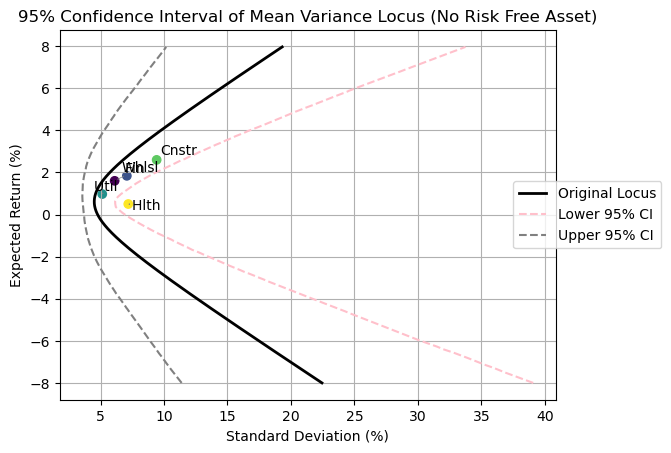

In [7]:
# no risk-free rate long-short portfolio
plotting.confidence_bands(df,
                          no_rf_mean_var_locus,
                          target_returns,
                          5,
                          0.05,
                          "95% Confidence Interval of Mean Variance Locus (No Risk Free Asset)",
                          False,
                          False)


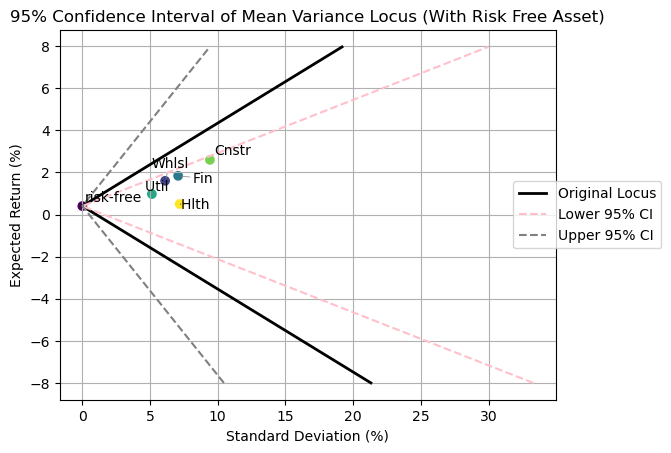

In [8]:
# risk-free rate long-short portfolio
plotting.confidence_bands(df_rf,
                          rf_mean_var_locus,
                          target_returns,
                          6,
                          0.05,
                          "95% Confidence Interval of Mean Variance Locus (With Risk Free Asset)",
                          True,
                          False)

# Plots A3

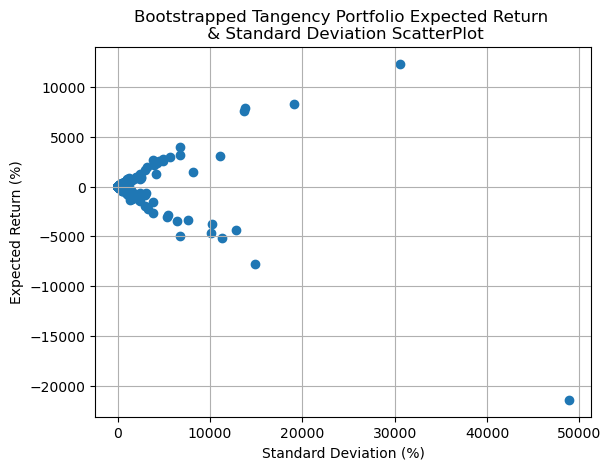

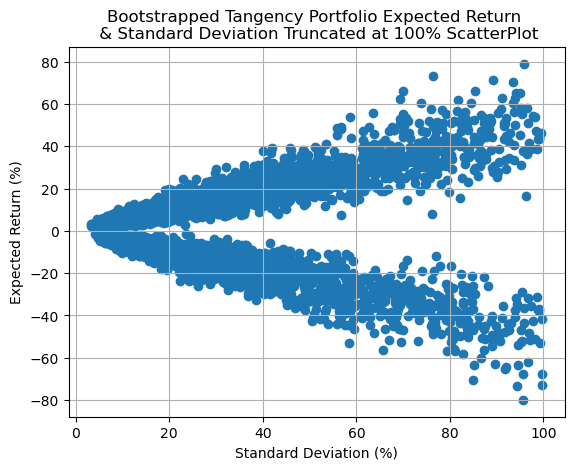

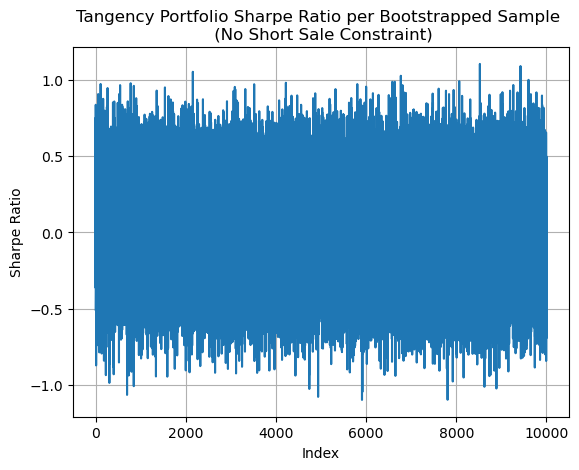

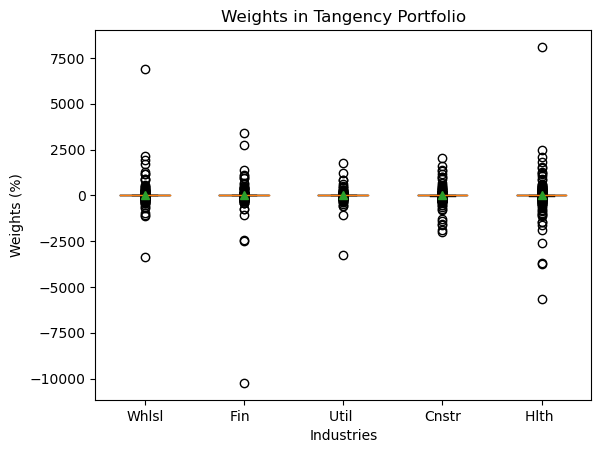

In [9]:
x = tangency_portfolio[:, 0]
y = tangency_portfolio[:, 1]

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set(xlabel='Standard Deviation (%)', ylabel='Expected Return (%)',
       title="Bootstrapped Tangency Portfolio Expected Return \n & Standard Deviation ScatterPlot")
ax.grid()
plt.show()

x = np.array(x)
y = np.array(y)
fig, ax = plt.subplots()
ax.scatter(x[x < 100], y[x < 100])
ax.set(xlabel='Standard Deviation (%)', ylabel='Expected Return (%)',
       title="Bootstrapped Tangency Portfolio Expected Return \n & Standard Deviation Truncated at 100% ScatterPlot")
ax.grid()
plt.show()



fig, ax = plt.subplots()
ax.plot(np.arange(1, (nb_bootstraps + 1)), (y-risk_free)/x)
ax.set(xlabel='Index', ylabel='Sharpe Ratio',
       title="Tangency Portfolio Sharpe Ratio per Bootstrapped Sample \n (No Short Sale Constraint)")
ax.grid()
plt.show()

# box plot of tangency portfolio weights
tangency_portfolio_weights = pd.DataFrame(tangency_portfolio_weights,
                                          columns=["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "])
plt.boxplot(tangency_portfolio_weights, labels=["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "], showmeans=True)
plt.ylabel("Weights (%)")
plt.xlabel("Industries")
plt.title("Weights in Tangency Portfolio")
plt.show()


# Plots A4 & A5

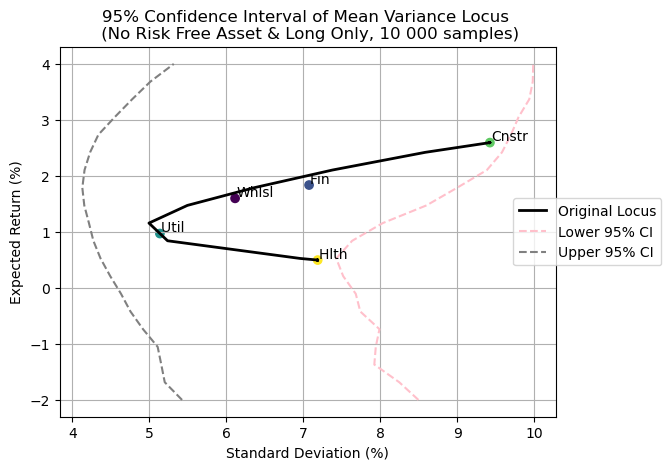

In [14]:
# no risk-free rate long-only
plotting.confidence_bands(df,
                          no_rf_mean_var_locus_no_short,
                          target_returns_no_short,
                          5,
                          0.05,
                          "95% Confidence Interval of Mean Variance Locus \n (No Risk Free Asset & Long Only, 10 000 samples)",
                          False,
                          True)

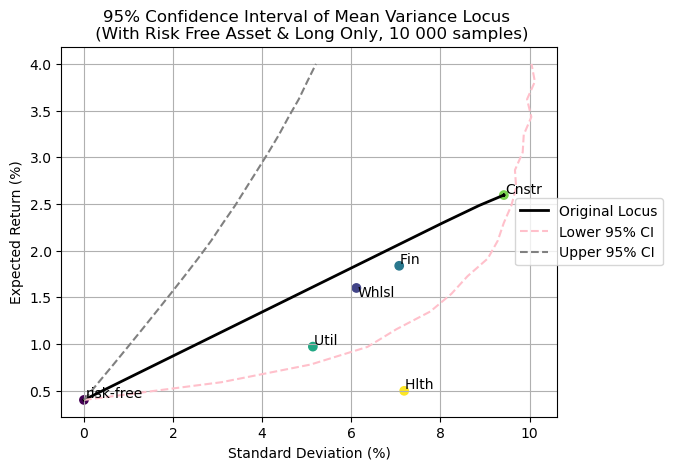

In [15]:
# risk-free rate long-only

plotting.confidence_bands(df_rf,
                          rf_mean_var_locus_no_short,
                          target_returns_no_short_rf,
                          6,
                          0.05,
                          "95% Confidence Interval of Mean Variance Locus \n (With Risk Free Asset & Long Only, 10 000 samples)",
                          True,
                          True)

# Plots A6

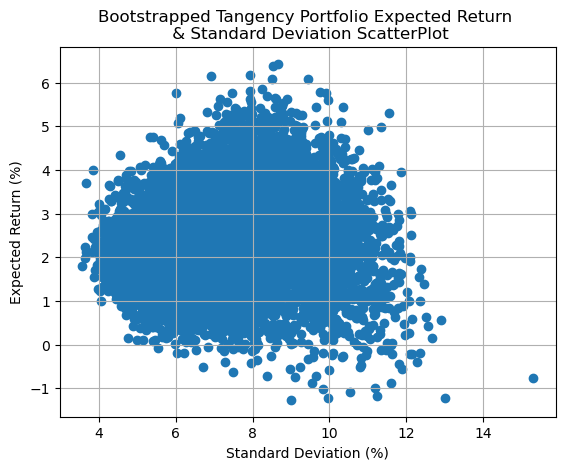

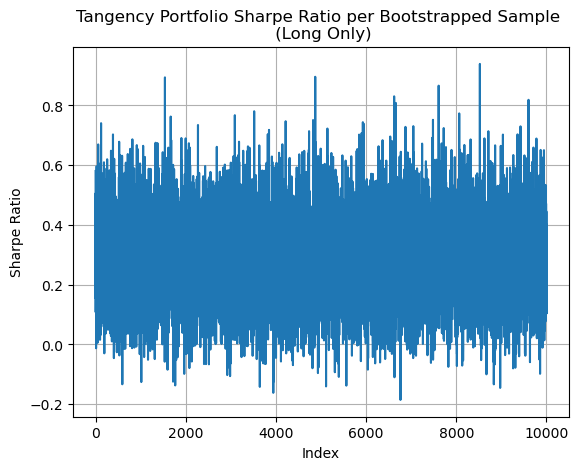

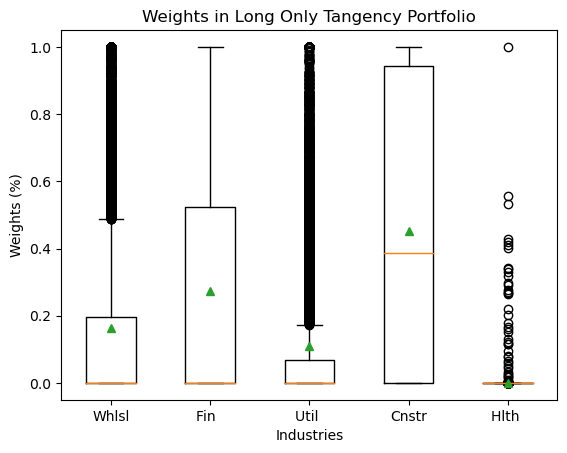

In [12]:
x = tangency_portfolio_no_short[:, 0]
y = tangency_portfolio_no_short[:, 1]

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set(xlabel='Standard Deviation (%)', ylabel='Expected Return (%)',
       title="Bootstrapped Tangency Portfolio Expected Return \n & Standard Deviation ScatterPlot")
ax.grid()
plt.show()


fig, ax = plt.subplots()
ax.plot(np.arange(1, (nb_bootstraps+1)), (y-risk_free)/x)
ax.set(xlabel='Index', ylabel='Sharpe Ratio',
       title="Tangency Portfolio Sharpe Ratio per Bootstrapped Sample \n (Long Only)")
ax.grid()
plt.show()

# box plot of tangency portfolio weights
tangency_portfolio_weights_no_short = pd.DataFrame(tangency_portfolio_weights_no_short,
                                                   columns=["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "])
plt.boxplot(tangency_portfolio_weights_no_short, labels=["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "], showmeans=True)
plt.title("Weights in Long Only Tangency Portfolio")
plt.xlabel("Industries")
plt.ylabel("Weights (%)")
plt.show()

# Additional Plots

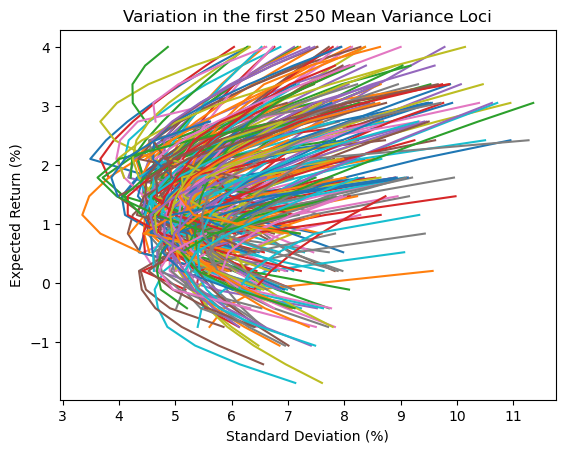

In [13]:
for i in range(250):
    indices = ~np.isnan(no_rf_mean_var_locus_no_short[i,:, 0])
    plt.plot(no_rf_mean_var_locus_no_short[i,:, 0][indices], no_rf_mean_var_locus_no_short[i,:, 1][indices])
plt.title("Variation in the first 250 Mean Variance Loci")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Expected Return (%)")
plt.show()